# CoLeaf CNN

## Imports and configurations

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from network import Net
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassConfusionMatrix, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

from trainer import CoLeafTrainer
from dataset import CoLeafDataset


In [4]:
IMG_SIZE        = 224
BATCH_SIZE      = 32
WORKERS         = 4
TRAIN_SPLIT     = 0.6
EPOCHS          = 50
LR              = 0.001
MODEL_VERSION   = "v1"
DATASET_PATH    = "./CoLeaf DATASET"
OUTPUT_PATH     = "./output"
MODEL_PATH      = f"./output/model_{MODEL_VERSION}.pth"

In [5]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Loading dataset

In [25]:
dataset = CoLeafDataset(
    data_dir=DATASET_PATH,
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),          
        transforms.ToTensor(),           
        transforms.Normalize(            
            mean=[0.5, 0.5, 0.5], 
            std=[0.5, 0.5, 0.5]
        )
    ])
)

torch.save(dataset, os.path.join(OUTPUT_PATH, "dataset.pt"))

Loading classes:   0%|          | 0/10 [00:00<?, ?it/s]

Loading images for class boron-B:   0%|          | 0/101 [00:00<?, ?it/s]

Loading images for class calcium-Ca:   0%|          | 0/162 [00:00<?, ?it/s]

Loading images for class healthy:   0%|          | 0/6 [00:00<?, ?it/s]

Loading images for class iron-Fe:   0%|          | 0/65 [00:00<?, ?it/s]

Loading images for class magnesium-Mg:   0%|          | 0/79 [00:00<?, ?it/s]

Loading images for class manganese-Mn:   0%|          | 0/83 [00:00<?, ?it/s]

Loading images for class more-deficiencies:   0%|          | 0/104 [00:00<?, ?it/s]

Loading images for class nitrogen-N:   0%|          | 0/64 [00:00<?, ?it/s]

Loading images for class phosphorus-P:   0%|          | 0/246 [00:00<?, ?it/s]

Loading images for class potasium-K:   0%|          | 0/96 [00:00<?, ?it/s]

In [6]:
# Load the dataset object. Set `weights_only=False` as we trust the source of the file.
dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/dataset.pt"), weights_only=False)

In [51]:
classes = dataset.classes
class_labels = dataset.labels
print(classes)

['boron-B', 'calcium-Ca', 'healthy', 'iron-Fe', 'magnesium-Mg', 'manganese-Mn', 'more-deficiencies', 'nitrogen-N', 'phosphorus-P', 'potasium-K']


In [13]:
# Split the dataset into train, validation, and test sets (60/20/20)
range_train, range_temp = train_test_split(
    range(len(dataset)),
    train_size=TRAIN_SPLIT,
    stratify=dataset.labels
)
range_valid, range_test = train_test_split(
    range_temp,
    test_size=0.5,
    stratify=[dataset.labels[i] for i in range_temp]
)

train_dataset = Subset(dataset, range_train)
val_dataset = Subset(dataset, range_valid)
test_dataset  = Subset(dataset, range_test)

In [ ]:
torch.save(train_dataset, os.path.join(OUTPUT_PATH, "datasets/train_dataset.pt"))
torch.save(val_dataset, os.path.join(OUTPUT_PATH, "datasets/val_dataset.pt"))
torch.save(test_dataset, os.path.join(OUTPUT_PATH, "datasets/test_dataset.pt"))

In [ ]:
train_dataset = torch.load(os.path.join(OUTPUT_PATH, "datsets/train_dataset.pt"), weights_only=False)
val_dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/val_dataset.pt"), weights_only=False)
test_dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/test_dataset.pt"), weights_only=False)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

## Training

In [8]:
net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

In [ ]:
trainer = CoLeafTrainer(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
)

trainer.train()
trainer.save_model(MODEL_PATH)
train_metrics = pd.DataFrame(trainer.metrics)
train_metrics.to_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), header=True, sep=';')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

## Output visualization


In [ ]:
train_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), sep=';')

### Model loss and accuracy

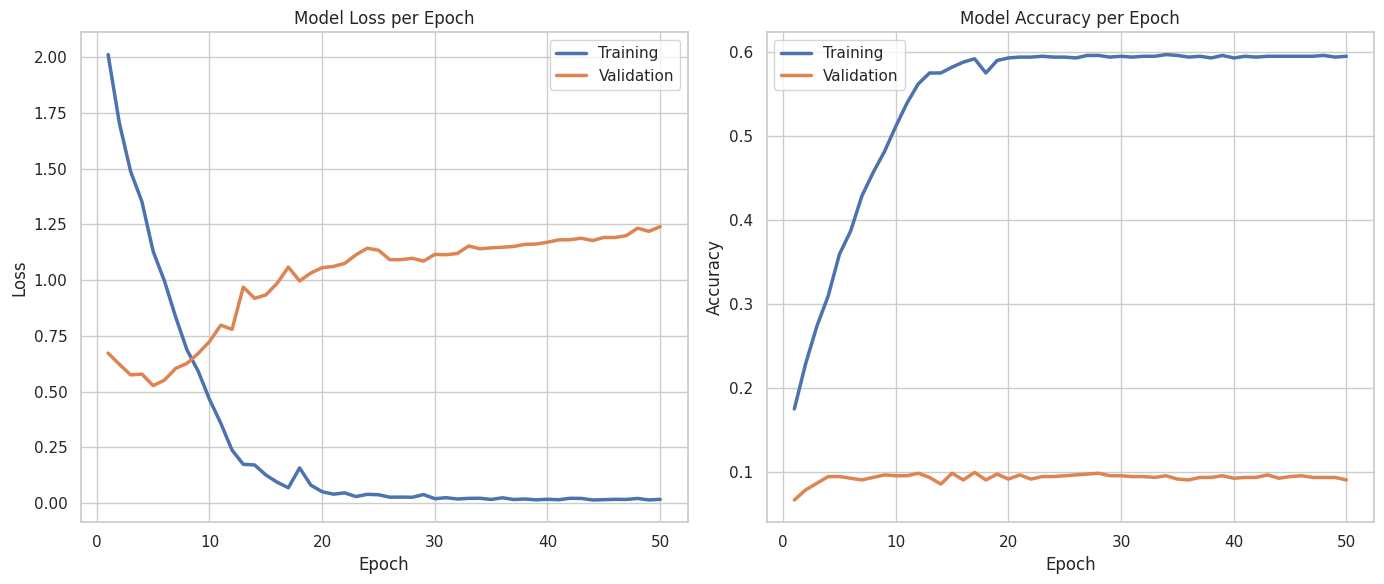

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

df_loss_wide = train_metrics.loc[:, ['train_loss', 'val_loss']]
df_loss_wide.columns = ['Training', 'Validation']
df_loss_wide['Epoch'] = df_loss_wide.index + 1

df_loss= pd.melt(
    df_loss_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Loss'
)

sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Type', linewidth=2.5, ax=axes[0])
axes[0].set_title('Model Loss per Epoch')
axes[0].legend(title='')

df_acc_wide = train_metrics.loc[:, ['train_acc', 'val_acc']]
df_acc_wide.columns = ['Training', 'Validation']
df_acc_wide['Epoch'] = df_acc_wide.index + 1
df_acc = pd.melt(
    df_acc_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Accuracy'
)

sns.lineplot(data=df_acc, x='Epoch', y='Accuracy', hue='Type', linewidth=2.5, ax=axes[1])
axes[1].set_title('Model Accuracy per Epoch')
axes[1].legend(title='')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/model_performance_{MODEL_VERSION}.png"))
plt.show()

## Testing

In [15]:
net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [24]:
metrics = {
    'cm': MulticlassConfusionMatrix(num_classes=len(classes)),
    'average_f1': MulticlassF1Score(num_classes=len(classes), average='micro'),
    'f1': MulticlassF1Score(num_classes=len(classes), average=None), 
    'average_precision': MulticlassPrecision(num_classes=len(classes), average='micro'), 
    'precision': MulticlassPrecision(num_classes=len(classes), average=None),
    'average_recall': MulticlassRecall(num_classes=len(classes), average='micro'),
    'recall': MulticlassRecall(num_classes=len(classes), average=None), 
}

for metric in metrics.values(): 
    metric.reset()

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for metric in metrics.values(): 
            metric.update(predicted, labels)
            
cm = metrics['cm'].compute().cpu().numpy()
avg_precision = metrics['average_precision'].compute().item()
avg_recall = metrics['average_recall'].compute().item()
avg_f1 = metrics['average_f1'].compute().item()

class_data = {
    'class': classes,
    'f1': metrics['f1'].compute().cpu().numpy(),
    'precision': metrics['precision'].compute().cpu().numpy(),
    'recall': metrics['recall'].compute().cpu().numpy(),
}

df_metrics = pd.DataFrame(class_data)
df_metrics.loc[len(classes)] = ["average", avg_f1, avg_precision, avg_recall]

In [26]:
df_metrics.round(4).to_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), index=False, sep=';')
np.save(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"), cm)

### Classification report

In [9]:
df_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), sep=';')

In [25]:
display(df_metrics)

,class,f1,precision,recall
0,boron-B,0.820513,0.842105,0.800000
1,calcium-Ca,0.794118,0.771429,0.818182
2,healthy,1.000000,1.000000,1.000000
3,iron-Fe,0.692308,0.692308,0.692308
4,magnesium-Mg,0.687500,0.687500,0.687500
5,manganese-Mn,0.625000,0.625000,0.625000
6,more-deficiencies,0.731707,0.750000,0.714286
7,nitrogen-N,0.733333,0.647059,0.846154
8,phosphorus-P,0.927835,0.957447,0.900000
9,potasium-K,0.702703,0.722222,0.684211


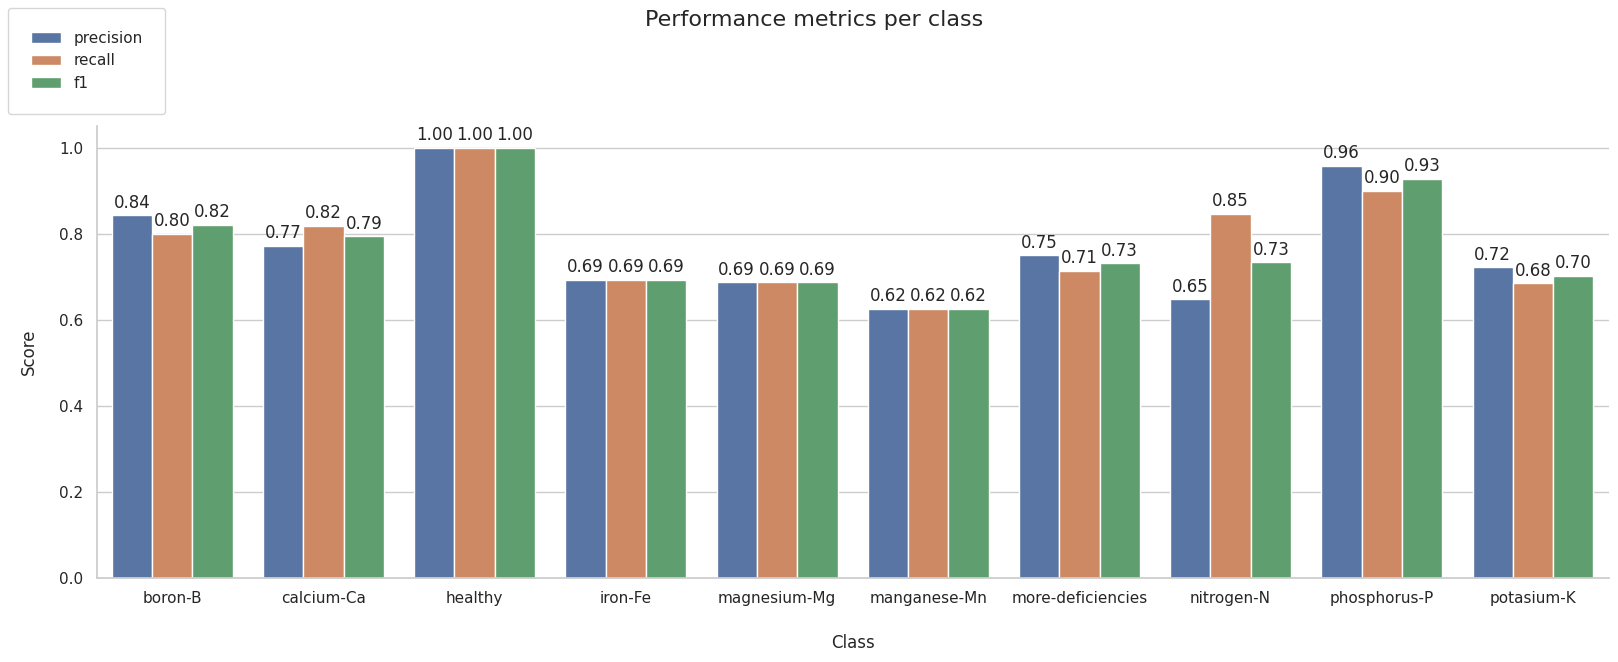

In [66]:
df_class_metrics = df_metrics[:-1]

df_melted = pd.melt(
    df_class_metrics,
    id_vars=['class'],
    value_vars=['precision', 'recall', 'f1'],
    var_name='Metric',
    value_name='Score'
)

g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="class",
    y="Score",
    hue="Metric",
    aspect=2.5,
    height=6
)

g.figure.suptitle('Performance metrics per class', fontsize=16, y=1.1)

sns.move_legend(g, "upper left", borderpad=1.5, title=None, frameon=True)
sns.set_theme(style="whitegrid")

for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.xlabel("Class", labelpad=20)
plt.ylabel("Score", labelpad=15)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/metrics_barchart_{MODEL_VERSION}.png"))
plt.show()

#### F1 Score vs. Class Proportion

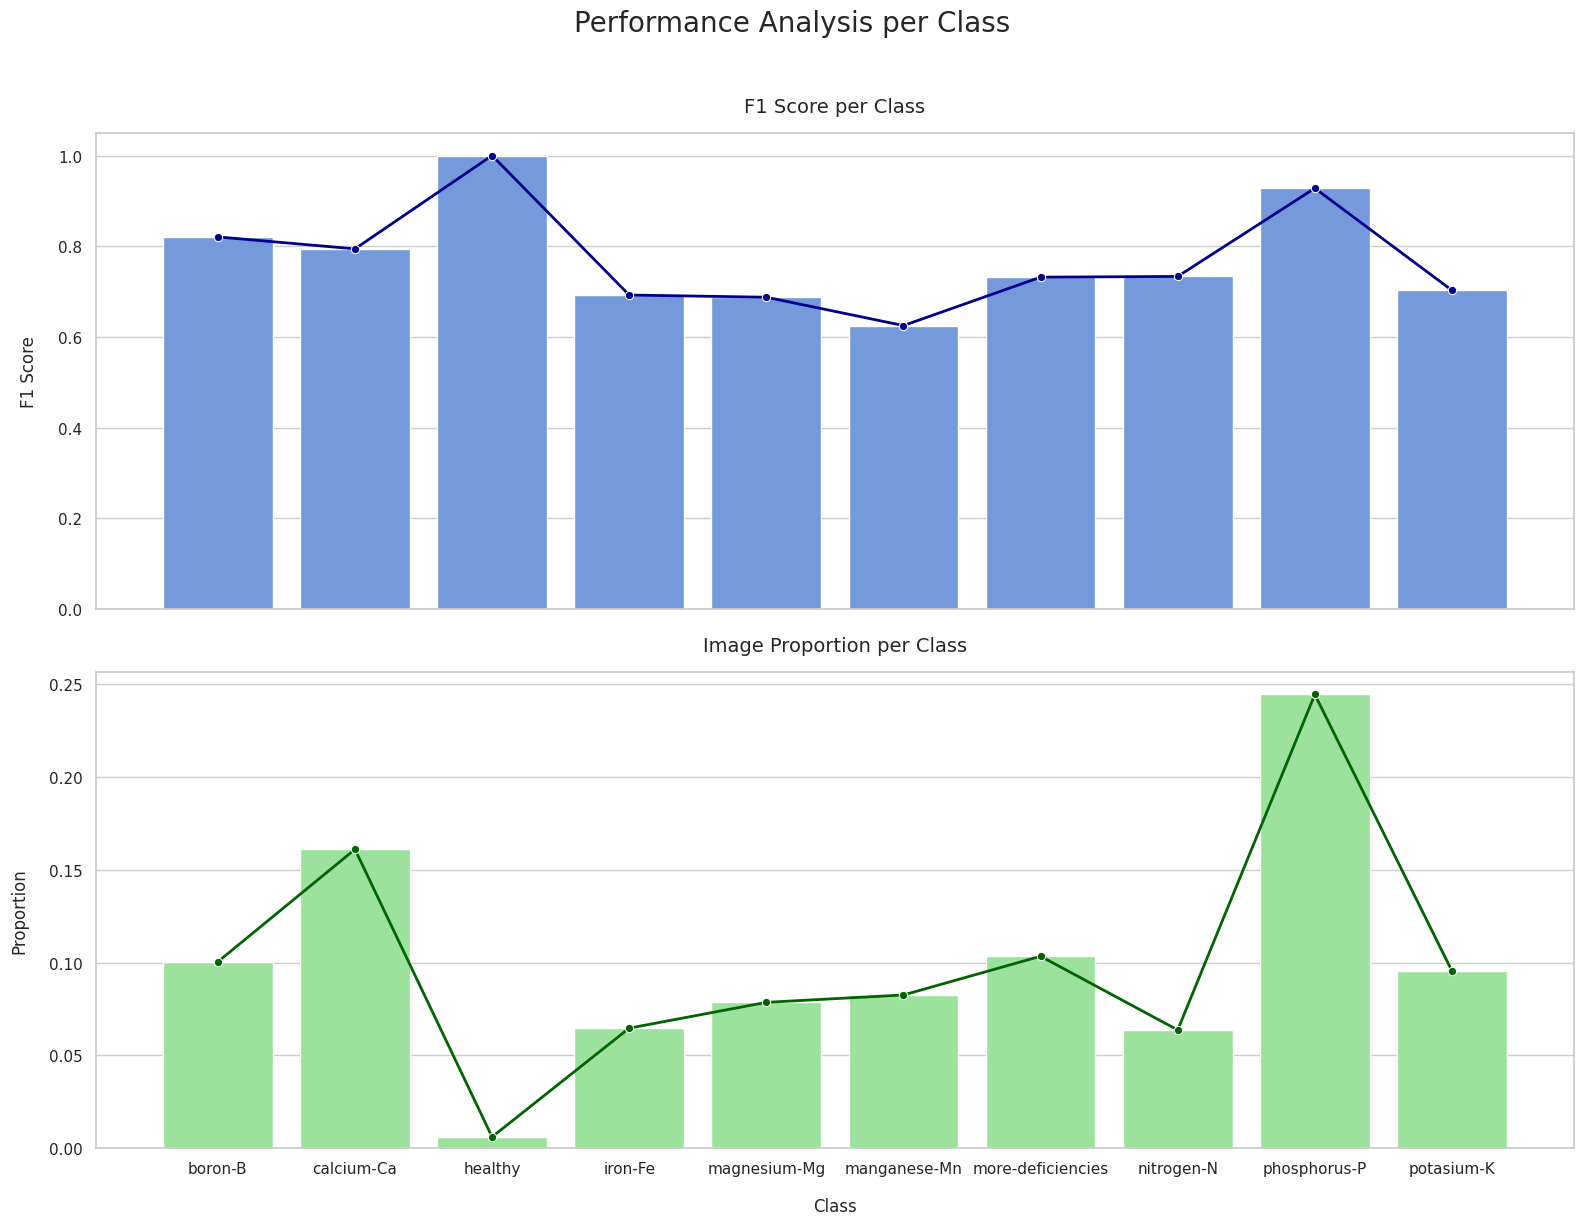

In [72]:
df_f1 = df_metrics.loc[df_metrics['class'] != 'average', ['class', 'f1']].copy()

total_images = len(class_labels)
image_counts = [class_labels.count(i) for i in range(len(classes))]
image_proportions = [count / total_images for count in image_counts]

df_plot_data = pd.DataFrame({
    'Class': classes,
    'F1 Score': df_f1['f1'].values,
    'Image Proportion': image_proportions
})

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Performance Analysis per Class', fontsize=20, y=1.02)

ax1 = axes[0]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='cornflowerblue',
    ax=ax1
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='darkblue',
    marker='o',
    linewidth=2,
    ax=ax1
)
ax1.set_title('F1 Score per Class', fontsize=14, pad=15)
ax1.set_ylabel('F1 Score', labelpad=15)
ax1.set_xlabel('')

ax2 = axes[1]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='lightgreen',
    ax=ax2
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='darkgreen',
    marker='o',
    linewidth=2,
    ax=ax2
)
ax2.set_title('Image Proportion per Class', fontsize=14, pad=15)
ax2.set_ylabel('Proportion', labelpad=15)
ax2.set_xlabel('Class', labelpad=15)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/f1_vs_class_proportion_{MODEL_VERSION}.png"))
plt.show()

### Confusion Matrix

In [ ]:
cm = np.load(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"))

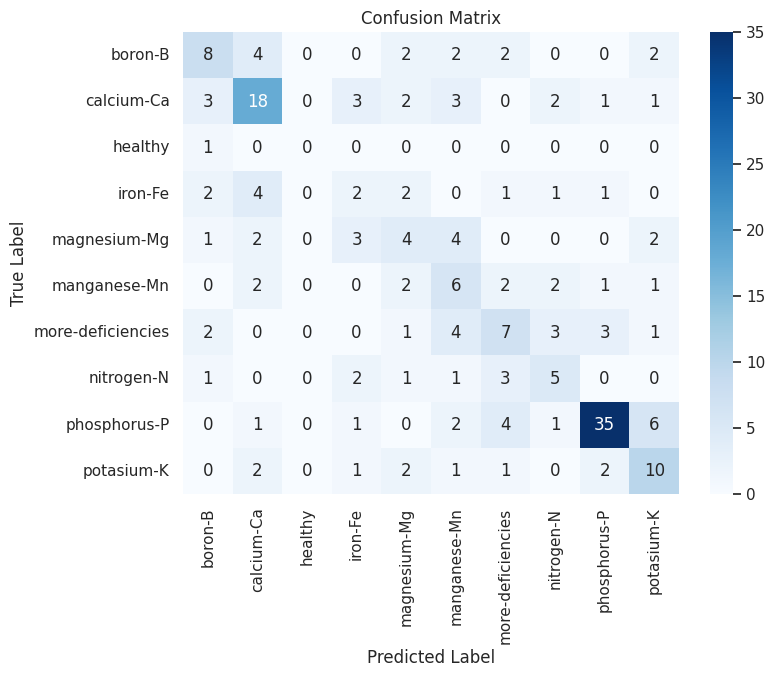

In [46]:
df = pd.DataFrame(cm, columns=classes, index=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/confusion_matrix_{MODEL_VERSION}.png"))
plt.show()

### ROC Curve